In [1]:
import nppar
import time
import numpy as np
import math
import datatable as dt
import time
import xarray
import os
import fileutils
import traceback
from datetime import datetime
import random
from functools import partial
from multiprocessing import Pool, Array, Process, Manager, Queue, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1 as axes_grid1
from multiprocessing import shared_memory

In [2]:
'''
get grid parameters
'''
def gridinfo():
    rdiff=2227
    minnorth=333237
    #maxwest=1160624
    minwest=1156167
    maxeast=2747676
    maxsouth=3504175
    gridwidth=((maxeast-minwest) % rdiff) + 1
    firstid = minwest-math.ceil((minwest-minnorth) / rdiff)*rdiff
    gridheight=math.ceil((maxsouth-firstid) / rdiff)
    return rdiff, firstid, gridwidth, gridheight

'''
walk folders to find all dataset files
'''
def walkmonthdays(sfolder):
    dayfiles=[]
    for dayf in fileutils.find_files(sfolder, '*_norm.csv', listtype="walk"):
        dayfiles+=[dayf]
    return dayfiles

'''
get grid x, y from grid ID
'''
def get_grid_xy(firstid, rdiff, _id,):
    row =int((_id-firstid)/rdiff)
    col = int(_id-firstid-rdiff*row)
    return row,col

'''
assign the tabular row to the x,y position of the 3D array (grid3D)
'''
def assignrow(grid3D, tabrow):
    row, col = get_xy(tabrow[0])
    grid3D[row, col, :]=tabrow[:]

'''
assign the tabular rows in (tabrows) to each corresponding x,y position of the shared 3D array (grid3D_sh)
'''            
def assignrowshared(grid3D_sh, tabrows):
    for i in range(tabrows.shape[0]):
        tabrow=tabrows[i,:]
        try:
            row, col = get_xy(tabrow[0])
            grid3D_sh[row, col]=tabrow[:]
            #print(row, col)
        except:
            "Error row: %s\n"%i+traceback.print_exc()

In [6]:
'''
plot graph lines (in wall list), parameter yscale defines y-axis scale to be logarithmic, linear etc.
''' 
def plotwall(wall,ncpus, ytitle="Time (sec)", yscale="linear"):
    plt.figure(figsize=(10,6))
    for wallline in wall: 
        plt.plot(range(1,ncpus+1), wall[wallline], label = wallline)
    plt.yscale(yscale)
    plt.xlabel("Number of CPUs")
    plt.ylabel(ytitle)
    plt.grid(visible=True, axis='y')
    plt.legend()
    plt.show()

In [21]:
'''
initialization of Grid parameters, empty 3D array, partial functions (with limited parameters) and loading of a daily dataset
''' 
rdiff, firstid, gridwidth, gridheight = gridinfo()
get_xy=partial(get_grid_xy, firstid, rdiff)
dayfiles=walkmonthdays('/data2/ffp/datasets/daily/')
#fday='/data2/ffp/datasets/daily/2021/08/20210823_norm.csv'
fday='/data2/ffp/datasets/daily/2015/09/20150923_norm.csv'
dt_df = dt.fread(fday)
firstfeat=dt_df.names.index('id')
npday = dt_df[:, firstfeat:].to_numpy(dt.float32) #each row of npday is a row of the tabular dataset
maxcpus=cpu_count()
featn = len(dt_df[:, firstfeat:].names)
ggrid = np.zeros((gridwidth, gridheight, featn)) #empty 3D array initialization
ggrid[:,:]=np.nan 
assignr=partial(assignrow, ggrid)
print('max cpu count %s'%maxcpus)
print('array rows: %s'%npday.shape[0])

max cpu count 16
array rows: 372945


### Simple python run

In [5]:
nruns=1
totalrun=0
start = time.time()
for i in range(npday.shape[0]):
    assignr(npday[i])
end = time.time()
print('time: %.2f sec'%(end-start))
pythonsimple=[end-start]*maxcpus

time: 3.30 sec


In [6]:
allwall={} # dictionary of graph lines list used for plotting
allwall['Simple Python Loop']=pythonsimple

### multiprocessing with shared memory

In [14]:
nruns=1
totalrun=0
ncpus=maxcpus
multishared=[]
for ncpus in range(1,maxcpus+1):
    start = time.time()
    procs=[]
    chunk = int(npday.shape[0] / ncpus)
    chunk_rem = npday.shape[0] % ncpus
    shm = shared_memory.SharedMemory(create=True, size=4*gridheight*gridwidth*featn)
    shDay = np.ndarray((gridheight, gridwidth, featn), dtype=np.float32, buffer=shm.buf)
    for cpu in range(ncpus-1):
        procs += [Process(target=assignrowshared, args=(shDay, npday[cpu*chunk:(cpu+1)*chunk]))]
        procs[cpu].start()
    procs += [Process(target=assignrowshared, args=(shDay, npday[(ncpus-1)*chunk:]))]
    procs[-1].start()
    for p in procs: p.join()
    shm.close()
    shm.unlink()
    shDay=None
    end = time.time()
    print('time: %.2f sec, cpu: %s'%((end-start),ncpus))
    multishared+=[end-start]


time: 3.81 sec, cpu: 1
time: 1.82 sec, cpu: 2
time: 1.40 sec, cpu: 3
time: 1.21 sec, cpu: 4
time: 1.14 sec, cpu: 5
time: 1.08 sec, cpu: 6
time: 1.08 sec, cpu: 7
time: 1.11 sec, cpu: 8
time: 1.17 sec, cpu: 9
time: 1.11 sec, cpu: 10
time: 1.15 sec, cpu: 11
time: 1.24 sec, cpu: 12
time: 1.32 sec, cpu: 13
time: 1.34 sec, cpu: 14
time: 1.34 sec, cpu: 15
time: 1.51 sec, cpu: 16


In [18]:
allwall['Multiprocessing with shared']=multishared

### cython with shared memory 

In [9]:
def cython_experiment(nruns=1, maxcpus=16, schedule=None, intens=0):
    print('cpu changes, runs per experiment: %s'%nruns)
    proctimes=[]
    speedtimes=[]
    walltimes=[]
    Tseq=0
    for nt in range(1,maxcpus+1):
        proctotal = 0
        walltotal = 0
        for run in range(nruns):
            start = time.time()
            stpr = time.process_time()
            id2xy, grid = nppar.fillcube(nt, npday, firstid, rdiff, gridwidth, gridheight,sched=schedule, intensive=intens)
            end = time.time()
            endpr = time.process_time()
            proctotal+=(endpr - stpr)
            walltotal+=(end - start)
            avgtw = walltotal/nruns
            avgtp = proctotal/nruns/nt
            if nt==1: 
                Tseqp=avgtp
                Tseqw=avgtw
        print('average time wall: %.2f sec, average time CPU: %.2f sec, threads: %s'%(avgtw, avgtp,nt))
        proctimes+=[avgtp]
        speedtimes+=[Tseqw/avgtw]
        walltimes+=[avgtw]
    return walltimes, speedtimes, proctimes

In [11]:
walltimes, speedtimes, proctimes = cython_experiment(nruns=5, maxcpus=maxcpus, intens=0, schedule='static')

cpu changes, runs per experiment: 5
average time wall: 2.23 sec, average time CPU: 2.23 sec, threads: 1
average time wall: 2.95 sec, average time CPU: 1.61 sec, threads: 2
average time wall: 2.13 sec, average time CPU: 0.85 sec, threads: 3
average time wall: 2.17 sec, average time CPU: 0.67 sec, threads: 4
average time wall: 2.02 sec, average time CPU: 0.52 sec, threads: 5
average time wall: 2.20 sec, average time CPU: 0.48 sec, threads: 6
average time wall: 1.93 sec, average time CPU: 0.36 sec, threads: 7
average time wall: 2.05 sec, average time CPU: 0.34 sec, threads: 8
average time wall: 1.98 sec, average time CPU: 0.34 sec, threads: 9
average time wall: 2.11 sec, average time CPU: 0.31 sec, threads: 10
average time wall: 1.96 sec, average time CPU: 0.29 sec, threads: 11
average time wall: 2.10 sec, average time CPU: 0.27 sec, threads: 12
average time wall: 1.92 sec, average time CPU: 0.22 sec, threads: 13
average time wall: 2.03 sec, average time CPU: 0.22 sec, threads: 14
average

In [19]:
allwall['Cython parallelization with OpenMP']=walltimes

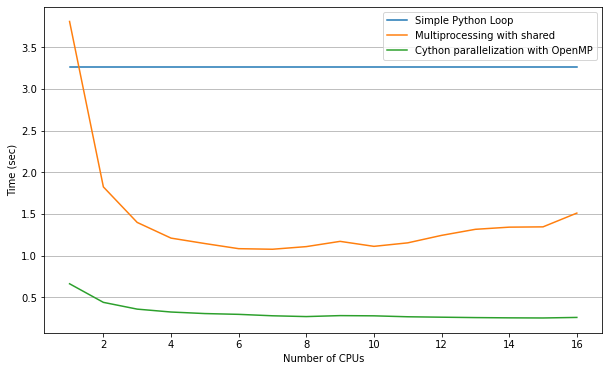

In [20]:
plotwall(allwall,maxcpus)

In [21]:
wallsp={}
wallsp['Simple Python Loop']=[1]*maxcpus
wallsp['Cython parallelization with OpenMP']=[allwall['Simple Python Loop'][0]/t for t in allwall['Cython parallelization with OpenMP']]
wallsp['Multiprocessing with shared']=[allwall['Simple Python Loop'][0]/t for t in allwall['Multiprocessing with shared']]


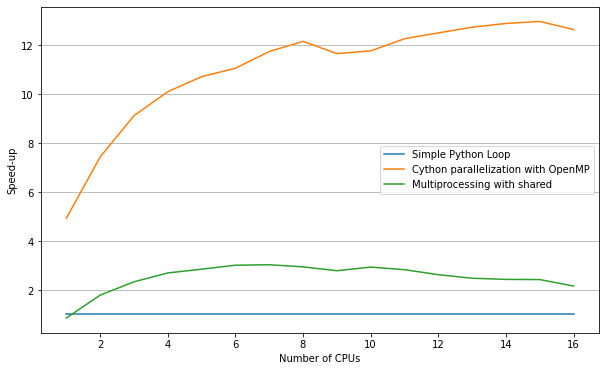

In [22]:
plotwall(wallsp,maxcpus,"Speed-up")

### cython experiment with intensive calculations

In [63]:
walltimes1, speedtimes1, proctimes1 = cython_experiment(nruns=1, maxcpus=maxcpus, intens=10000, schedule='static')

cpu changes, runs per experiment: 1
average time wall: 26.94 sec, average time CPU: 26.94 sec, threads: 1
average time wall: 14.56 sec, average time CPU: 14.32 sec, threads: 2
average time wall: 9.82 sec, average time CPU: 9.64 sec, threads: 3
average time wall: 7.48 sec, average time CPU: 7.15 sec, threads: 4
average time wall: 6.07 sec, average time CPU: 5.84 sec, threads: 5
average time wall: 5.07 sec, average time CPU: 4.85 sec, threads: 6
average time wall: 4.40 sec, average time CPU: 4.16 sec, threads: 7
average time wall: 3.87 sec, average time CPU: 3.65 sec, threads: 8
average time wall: 3.53 sec, average time CPU: 3.24 sec, threads: 9
average time wall: 3.20 sec, average time CPU: 2.95 sec, threads: 10
average time wall: 3.30 sec, average time CPU: 2.82 sec, threads: 11
average time wall: 3.40 sec, average time CPU: 2.71 sec, threads: 12
average time wall: 3.17 sec, average time CPU: 2.54 sec, threads: 13
average time wall: 3.02 sec, average time CPU: 2.49 sec, threads: 14
ave

In [85]:
wallsp1={}
wallsp1['Cython OpenMP']=[walltimes[0]/t for t in walltimes]
wallsp1['Cython OpenMP intensive calculations']=[walltimes1[0]/t for t in walltimes1]

In [82]:
cputimes={}
cputimes['Cython OpenMP wall times']=walltimes
cputimes['Cython OpenMP Avg CPU process time']=proctimes
cputimes['Cython OpenMP wall times intensive calculations']=walltimes1
cputimes['Cython OpenMP intens. calc. Avg CPU proc time']=proctimes1

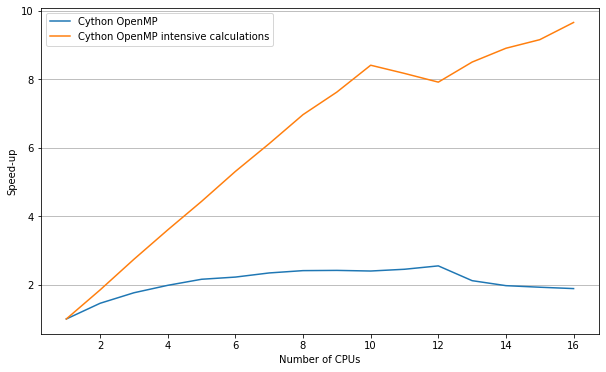

In [86]:
plotwall(wallsp1,maxcpus,"Speed-up")

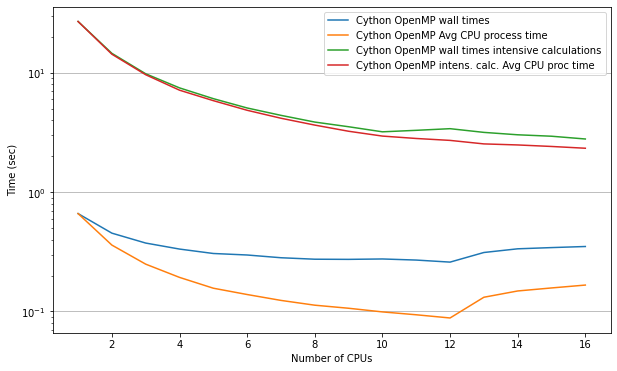

In [84]:
plotwall(cputimes,maxcpus,"Time (sec)", yscale='log')

### cython (with shared memory) chunks 

In [13]:
print('chunk changes')
nt = 10
print('rows / threads: %.0f threads: %s' % ((npday.shape[0] / nt),nt))
nruns=20
for cs in range(1,400000,10000):
    totalrun = 0
    for run in range(nruns):
        start = time.time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, 'static', cs)
        end = time.time()
        totalrun+=(end - start)
        avgt = totalrun/nruns
        if nt==1: Tseq=avgt
    print('average time: %.2f chunk: %s'%(totalrun/nruns, cs))

chunk changes
rows / threads: 37292 threads: 10
time: 0.32 chunk: 1
time: 0.28 chunk: 10001
time: 0.28 chunk: 20001
time: 0.29 chunk: 30001
time: 0.26 chunk: 40001
time: 0.27 chunk: 50001
time: 0.28 chunk: 60001
time: 0.29 chunk: 70001
time: 0.31 chunk: 80001
time: 0.32 chunk: 90001
time: 0.33 chunk: 100001
time: 0.34 chunk: 110001
time: 0.36 chunk: 120001
time: 0.37 chunk: 130001
time: 0.38 chunk: 140001
time: 0.39 chunk: 150001
time: 0.40 chunk: 160001
time: 0.41 chunk: 170001
time: 0.43 chunk: 180001
time: 0.43 chunk: 190001
time: 0.44 chunk: 200001
time: 0.45 chunk: 210001
time: 0.46 chunk: 220001
time: 0.48 chunk: 230001
time: 0.49 chunk: 240001
time: 0.50 chunk: 250001
time: 0.51 chunk: 260001
time: 0.52 chunk: 270001
time: 0.53 chunk: 280001
time: 0.54 chunk: 290001
time: 0.54 chunk: 300001
time: 0.58 chunk: 310001
time: 0.58 chunk: 320001
time: 0.58 chunk: 330001
time: 0.58 chunk: 340001
time: 0.59 chunk: 350001
time: 0.61 chunk: 360001
time: 0.62 chunk: 370001
time: 0.63 chunk

### cython (with shared memory) OpenMP schedules

In [ ]:
nt = 14
nruns=30
print('optimum rows / threads: %.0f, threads: %s, runs per experiment: %s' % ((npday.shape[0] / nt),nt, nruns))
for i in range(3):
    id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, None)
schedules = [None, 'static', 'dynamic', 'guided']
random.shuffle(schedules)
for schedule in schedules:
    totalrun = 0
    for run in range(nruns):
        start = time.time()
        id2xy, grid = nppar.fillcube(nt, npday, firstid,  rdiff, gridwidth, gridheight, schedule)
        end = time.time()
        totalrun+=(end - start)
    print('average time: %.2f sec, schedule: %s'%(totalrun/nruns, schedule))

#xaday=xarray.DataArray(data=grid, dims=["x", "y", "feature"],  coords=dict(x=range(gridwidth), y=range(gridheight), feature=range(len(dt_df.names)-1)))



### Tabular to 3D Conversion plus IO read/write (csv to netcdf)

In [8]:
'''
load csv tabular dataset, convert to 3D array, write file as netcdf
'''
def creategrid_xs_small(rdiff, firstid, gridwidth, gridheight, dayfile, pcpus, ccpus, queue):
    #print(rdiff, firstid, gridwidth, gridheight, dayfile, pcpus, ccpus)
    try:
        stpr = time.process_time()
        orig_path = os.path.dirname(dayfile)
        fname = os.path.basename(dayfile)
        daygrid = "%s_grid.nc" % (fname[0:8])
        #if os.path.isfile(os.path.join(orig_path, daygrid)): return
        dt_df = dt.fread(dayfile, nthreads=1)#pcpus)
        firstfeat = dt_df.names.index('id')
        #npday = dt_df[:, firstfeat:].to_numpy(dt.float32)

        dynamic_feat=['id', 'max_temp', 'min_temp', 'mean_temp', 'res_max',
         'dom_vel', 'rain_7days', 
         'ndvi_new', 'evi', 'lst_day', 'lst_night', 'max_dew_temp',
         'mean_dew_temp', 'min_dew_temp', 'fire', 'dir_max_1', 'dir_max_2',
         'dir_max_3', 'dir_max_4', 'dir_max_5', 'dir_max_6', 'dir_max_7',
         'dir_max_8', 'dom_dir_1', 'dom_dir_2', 'dom_dir_3', 'dom_dir_4',
         'dom_dir_5', 'dom_dir_6', 'dom_dir_7', 'dom_dir_8',
        'frequency','f81',]

        dyn_df = dt_df[:, dynamic_feat]
        npday = dyn_df.to_numpy(dt.float32)
        #print(npday.shape)
        id2xy, grid = nppar.fillcube(ccpus, npday, firstid, rdiff, gridwidth, gridheight,sched='static', intensive=0)
        #print('finished')
        vardict = {}
        for i in range(0, len(dyn_df.names)):
            varname = dyn_df.names[i]
            if dyn_df.names[i] == 'x' or dyn_df.names[i] == 'y':
                varname = '%spos' % varname
            vardict[varname] = (["x", "y", "time"], np.expand_dims(grid[:, :, i], axis=2))
        t = datetime.strptime(os.path.basename(dayfile)[0:8], '%Y%m%d')
        xsday = xarray.Dataset(data_vars=vardict, coords=dict(x=range(gridwidth), y=range(gridheight), time=[t]))
        xsday.to_netcdf(os.path.join(orig_path, daygrid))
        #print("Successfull convertion %s" % dayfile)
        epr = time.process_time()
        queue.put(epr-stpr)
    except:
        print("Fail to convert %s" % dayfile)
        traceback.print_exc()
        with open("/data2/ffp/datasets/daily/failedgrids.log", "a") as f:
            f.write(dayfile)

def new_process(creategrid, proclist, day, pthreads, cthreads):
    q=Queue()
    proclist += [{'proc':Process(target=creategrid, args=(day, pthreads, cthreads, q)), 'queue': q}]
    proclist[-1]['proc'].start()

    
'''
execute parallel conversion end-to-end for the files in 'days' list 
using 'pthreads' number of python threads for the end-to-end process
and 'cthreads' number of cython threads for the convertion in memory process
'''
def create_xs_files(creategrid, days, pthreads, cthreads):
    procs=[]
    proctimetotal=0
    dayscompleted=[]
    #print(days)
    for cpu in range(pthreads):
        d=days.pop()
        dayscompleted+=[d]
        #print('initial proc')
        new_process(creategrid, procs, d, pthreads, cthreads)
    while len(procs)>0:
        time.sleep(0.1)
        for p in procs:
            try:
                proctimetotal+=p['queue'].get_nowait()
            except:
                pass
            if not p['proc'].is_alive():
                #print('remove, tot procs: %d'%len(procs))
                procs.remove(p)
                #print('tot procs: %d'%len(procs))
        while len(procs)<pthreads:
            if len(days)==0: break
            #print('new proc')
            d = days.pop()
            dayscompleted += [d]
            new_process(creategrid, procs, d, pthreads, cthreads)
    return proctimetotal

'''
execute parallel conversion end-to-end for the files in 'days' list 
using 'pthreads' number of python threads for the end-to-end process
and 'cthreads' number of cython threads for the convertion in memory process
'''
def dataset_conv_opt(creategrid, maxcpus, dayfiles):
    nruns=1
    totalrun=0
    ctr=range(2,maxcpus+1,1)
    ptr=range(2,maxcpus+1,1)
    atimes2=np.zeros((max(list(ctr))+1,max(list(ptr))+1,2))
    for cthreads in ctr:
        for pthreads in ptr:
            start=time.time()
            nfiles=pthreads
            proctime=create_xs_files(creategrid, dayfiles[:nfiles], pthreads, cthreads)
            end=time.time()
            print('wall time: %.1f sec, process time: %.1f sec, python threads %s, cython threads %s' % (end - start, proctime, pthreads, cthreads))
            atimes2[cthreads, pthreads,:]=np.array([end-start,proctime])[:]
    return atimes2       

In [6]:
'''
plot performance heatmap with cython python threads combinations
'''
def plotheatmap(atimes, title1='Wall time', title2='Process (CPU) time'):
    fig = plt.figure(figsize=(12, 6))
    grid = axes_grid1.AxesGrid(
        fig, 111, nrows_ncols=(1, 2), axes_pad = 0.5, cbar_location = "right",
        cbar_mode="each", cbar_size="7%", cbar_pad="5%",)
    data=atimes[1:,1:,0]
    im0 = grid[0].imshow(data, cmap='turbo', interpolation='None')
    grid.cbar_axes[0].colorbar(im0)
    # Show all ticks and label them with the respective list entries
    grid[0].set_xticks(np.arange(data.shape[1]), labels=np.arange(1,data.shape[1]+1))
    grid[0].set_yticks(np.arange(data.shape[0]), labels=np.arange(1,data.shape[0]+1))
    grid[0].set_ylabel('# cython threads')
    grid[0].set_xlabel('# python threads')
    grid[0].title.set_text(title1)
    #ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
    if not title2 is None:
        data=atimes[1:,1:,1]
        im1 = grid[1].imshow(data, cmap='turbo', interpolation='None')
        grid[1].set_xticks(np.arange(data.shape[1]), labels=np.arange(1,data.shape[1]+1))
        grid[1].set_xlabel('# python threads')
        grid[1].title.set_text(title2)
        grid.cbar_axes[1].colorbar(im1)
    

In [39]:
creategrid = partial(creategrid_xs_small, rdiff, firstid, gridwidth, gridheight)

In [ ]:
atimes2=dataset_conv_opt(creategrid, 2, dayfiles)
np.save('conv_thread_eq_files_02',atimes2)

### end-to-end dataset conversion performance

In [22]:
ncpus=maxcpus
#ncpus=16
ctr=range(1,ncpus+1,1)
ptr=range(1,ncpus+1,1)
atimes2=np.load('tab2convtimes2.npy')
#atimes2=np.load('conv_thread_eq_files_04.npy')

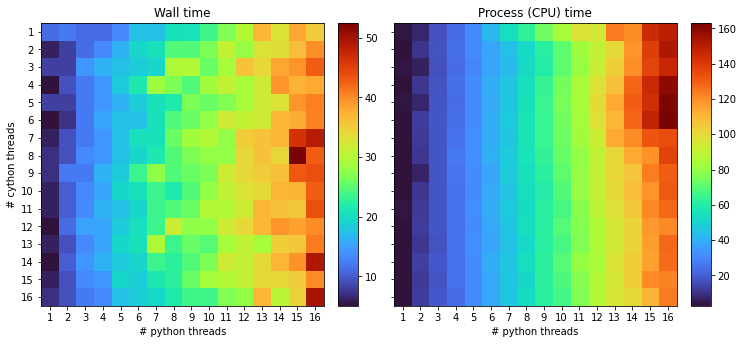

In [23]:
plotheatmap(atimes2)

In [24]:
atimes3=atimes2.copy()
for p in ptr: atimes3[:,p]=atimes2[:,p]/p

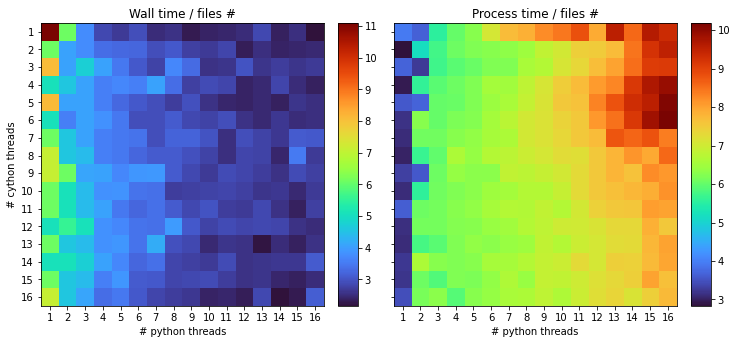

In [25]:
plotheatmap(atimes3,'Wall time / files #', 'Process time / files #')

In [26]:
atimes4=atimes2.copy()
for j in ptr:
    atimes4[1:,j,0]=atimes2[1,1,0]*j/atimes2[1:,j,0]
    atimes4[1:,j,1]=atimes2[1:,j,1]/j

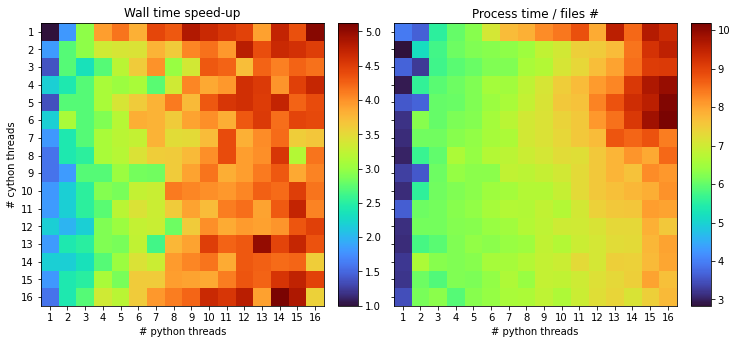

In [27]:
plotheatmap(atimes4, 'Wall time speed-up', 'Process time / files #')

In [28]:
#select indices for threads, cthreads where \speed-up >0.9 max speed-up into array best_speedup_idx
bestthres=0.9
best_speedup_idx=np.where(atimes4[:,:,0]>bestthres*atimes4[:,:,0].max())
best_speedup_idx

(array([ 1,  1,  1,  1,  2,  2,  4,  5,  5, 11, 13, 13, 15, 16, 16, 16, 16]),
 array([ 9, 10, 14, 16, 12, 14, 16, 12, 14, 15, 13, 15, 15, 10, 12, 14, 15]))

In [29]:
#select speed-up, process-time/file values speed-up >0.9 max speed-up into best_speedup_val
best_speedup_val=atimes4[atimes4[:,:,0]>bestthres*atimes4[:,:,0].max()]
best_speedup_val

array([[4.82584363, 8.21780804],
       [4.67121912, 8.41714974],
       [4.70735042, 8.56270718],
       [5.04349423, 9.34403663],
       [4.7763377 , 7.50438112],
       [4.66976611, 8.43960477],
       [4.6899557 , 9.91555258],
       [4.61507721, 8.29928797],
       [4.70454841, 9.31969371],
       [4.70553829, 8.04736979],
       [4.98699502, 7.25486561],
       [4.69305044, 7.77098529],
       [4.72930264, 7.99719829],
       [4.6701357 , 6.637085  ],
       [4.78272413, 7.21041537],
       [5.12285337, 7.12599365],
       [4.84589984, 7.43368513]])

In [30]:
#select index where we have max process-time/file in best_speedup_val
best_max_idx=np.argmax(best_speedup_val[:,1])
best_max_idx

6

In [31]:
atimes4[best_speedup_idx[0][best_max_idx], best_speedup_idx[1][best_max_idx]]

array([4.6899557 , 9.91555258])

In [32]:
#show pthreads cthreads for max process-time/file in best_speedup_idx
best_speedup_idx[0][best_max_idx], best_speedup_idx[1][best_max_idx]

(4, 16)